# Feature Engineering

## 1 - Notebook Configuration

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# display preferences
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

## 2 - Custom Functions

In [2]:
# function to calculate rolling exponentioally weighted moving average
def rwma(group, min_periods, span):
    # perform the ewma
    kwargs = dict(ignore_na=False, span=span, min_periods=min_periods, adjust=True)
    result = group.ewm(**kwargs).mean().shift().reset_index()
    result.rename(columns={result.columns[-1]: 'rwma'}, inplace=True)
    return result

In [3]:
# function to calculate rolling weighted moving average
def rmean(group,min_periods):
    # perform the mean
    kwargs = dict(window='3650d', min_periods=min_periods, win_type=None)
    #kwargs = dict(window='1825d', min_periods=min_periods, win_type=None)
    result = group.rolling(**kwargs).mean().shift().reset_index()
    result.rename(columns={result.columns[-1]: 'rmean'}, inplace=True)
    return result

## 3 - Load Data, Examine and Prep

In [4]:
df = pd.read_csv("data/team/new_intl_results.csv")

In [5]:
# note: some teams played twice on certain dates (e.g. Chile on 5/30/2010)

In [6]:
df.date = df.date.values.astype("datetime64")
df['year'] = pd.DatetimeIndex(df['date']).year

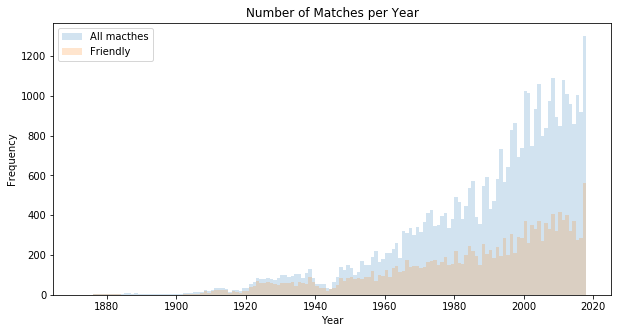

In [7]:
# create yearly bins for plotting
year_bins = np.linspace(min(df.year),max(df.year), max(df.year) - min(df.year) + 1)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df['year'], bins = year_bins, alpha = 0.2, label = 'All macthes')
ax.hist(df[df['tournament'] == 'Friendly']['year'], bins = year_bins, alpha = 0.2, label = 'Friendly')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Number of Matches per Year')
ax.legend()
plt.show()

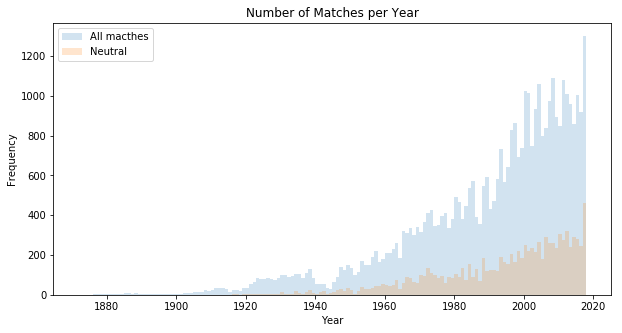

In [8]:
# create yearly bins for plotting
year_bins = np.linspace(min(df.year),max(df.year), max(df.year) - min(df.year) + 1)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df['year'], bins = year_bins, alpha = 0.2, label = 'All macthes')
ax.hist(df[df['neutral'] == 1]['year'], bins = year_bins, alpha = 0.2, label = 'Neutral')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Number of Matches per Year')
ax.legend()
plt.show()

Two observations:
 - Most matches are hosted by one of the teams.  Neutral field matches currently represent about 25% of matches played.
 - A high percentage of matches fall in the 'Friendly' category.  We will have to make a decision in terms of how to include these matches in our feature engineering process.  An argument could be made to ignore these matches because the stakes are lower, but discarding them would result in a fairly large loss of data.


## 4 - Create Intermediary Features

In [9]:
# Exclude world cup matches
df = df[df['date'] < '2018-06-14']

### 4.1 Result

In [10]:
# result variable
# constructed as follows:
# 1 for win
# 0 for draw
# -1 for loss
df['result'] = np.sign(df.home_score - df.away_score)

### 4.2 Result-Plus

In [11]:
# result adjusted for venue
# -0.5 penalty if result obtained on home soil
# +0.5 reward if result obtained on opponent soil 
# Note: no penalty if achieved on neutral field)
df['result_plus'] = np.sign(df.home_score - df.away_score) - (.25 * (df.neutral==False)) ## put back to 25

### 4.3 Sorted Match-Up

In [12]:
# Create a lookup value for all unique historical match-ups

df['unsorted_matchup'] = df['home_team'] + '|' + df['away_team']

df['sorted_matchup'] = np.where(df['home_team'] < df['away_team'], 
                                df['home_team'] + '|' + df['away_team'],
                                df['away_team'] + '|' + df['home_team'])

### 4.4 Sorted Match-Up Result

In [13]:
# Store result of the sorted match up
df['sorted_result'] = np.where(df['home_team'] < df['away_team'], 
                               df['result'] ,
                               df['result'] * -1)

### 4.5 Sorted Match-Up Result-Plus

In [14]:
# Store "result plus" for the sorted match up
df['sorted_result_plus'] = np.where(df['home_team'] < df['away_team'], 
                                    df['result_plus'] ,
                                    df['result_plus'] * -1)

## 5 - Create Model Features

Now that the required intermediary fearures have been created, we will go on to split our data set into training and testing subsets.

In [15]:
df = df.sort_values('date')

### 5.1 - Historical Record vs Opponent

Defintions:
 - **Historical Record vs Opponent (HRVO):**
     - **Variable Name**: hrvo_rwma
     - **Description**: Lagging indicator of past performance vs opponent based on the _results_ variable



 - **Historical Record vs Opponent "Plus" (HRVOP):**
     - **Variable Name**: hrvop_rwma
     - **Description**: Lagging indicator of past performance vs opponent based on the _results-plus_ variable (which reduces penalizes vins, draws and losses on home turf.

### 5.1.1 - Generate Features

In [16]:
# Create fake rows to store forward int'l ranking (this is needed because our new features are lagging variables)
fake_df1 = df.loc[df.groupby(['sorted_matchup']).date.idxmax()]
fake_df1['date'] = '2099-12-31'
fake_df1['tournament'] = 'Placeholder'
df = pd.concat([df,fake_df1], sort=True)

In [17]:
df.set_index('date',inplace=True,drop=True)

In [18]:
# create new dataframe (df_vs_oppo) to store rolling record vs opponent using custom rolling weighted average function (rwma)
df_vs_oppo  = df.groupby('sorted_matchup')[['sorted_result','sorted_result_plus']].apply(rwma,0,25)

In [19]:
df.reset_index(inplace=True)

In [20]:
# rename columns, as group by generates undesirable column names
df_vs_oppo = df_vs_oppo.rename(columns={'sorted_result':'hrvo_rwma', 
                                        'rwma':'hrvop_rwma' })

df_vs_oppo.reset_index(inplace=True)

df_vs_oppo = df_vs_oppo.drop(columns = 'level_1')

# fill first match-up where values for sorted_result_rwma and sorted_result_plus_rwma will always be N/A with zeroes.
df_vs_oppo['hrvo_rwma'] = df_vs_oppo['hrvo_rwma'].fillna(0)
df_vs_oppo['hrvop_rwma'] = df_vs_oppo['hrvop_rwma'].fillna(0)

In [21]:
# below is needed to handle duplicates due to certain teams playing two matches on the same date
df_vs_oppo = df_vs_oppo.groupby(['sorted_matchup','date']).mean()
df_vs_oppo = df_vs_oppo.reset_index()

### 5.1.2 - Examine Features

Let's take a look at match results vs our newly engineered variables:

In [22]:
# merge feature into df
df = df.merge(df_vs_oppo[['sorted_matchup','date','hrvo_rwma','hrvop_rwma']], 
                  how = 'inner',
                  left_on=['sorted_matchup','date'], 
                  right_on=['sorted_matchup','date'])


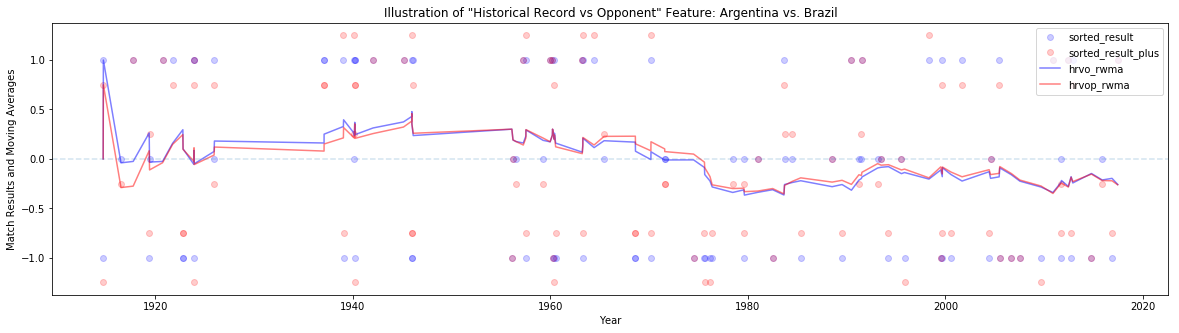

In [23]:
temp_df = df[(df['sorted_matchup'] == 'Argentina|Brazil') & (df.date < '2099-12-31')] 

fig, ax = plt.subplots(1,1,figsize = (20,5))

ax.plot(temp_df['date'] , temp_df['sorted_result'], 'o', label = 'sorted_result', alpha = 0.2, color = 'blue')
ax.plot(temp_df['date'] , temp_df['sorted_result_plus'] , 'o', label = 'sorted_result_plus', alpha = 0.2, color = 'red')
ax.plot(temp_df['date'] , temp_df['hrvo_rwma'] , '-', label = 'hrvo_rwma', alpha = 0.5, color = 'blue')
ax.plot(temp_df['date'] , temp_df['hrvop_rwma'] , '-', label = 'hrvop_rwma', alpha = 0.5, color = 'red')
ax.axhline(0, linestyle = '--', alpha = 0.2)

ax.set_xlabel('Year')
ax.set_ylabel('Match Results and Moving Averages')
ax.set_title('Illustration of "Historical Record vs Opponent" Feature: Argentina vs. Brazil')

ax.legend()
plt.show()

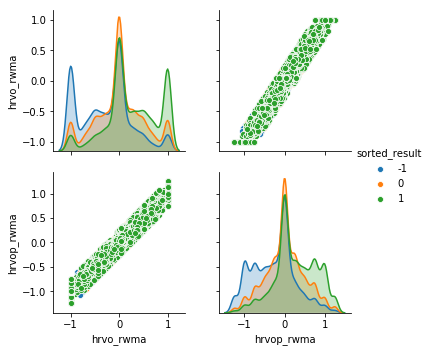

In [24]:
sns.pairplot(df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

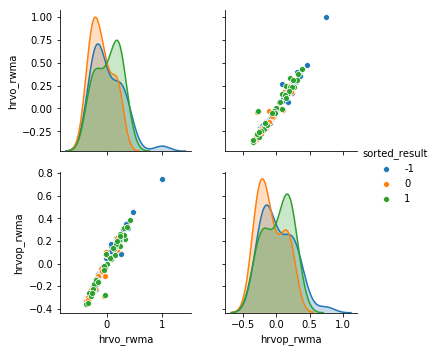

In [25]:
# Look at France vs Spain
temp_df = df[(df['sorted_matchup'] == 'Argentina|Brazil')]
sns.pairplot(temp_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

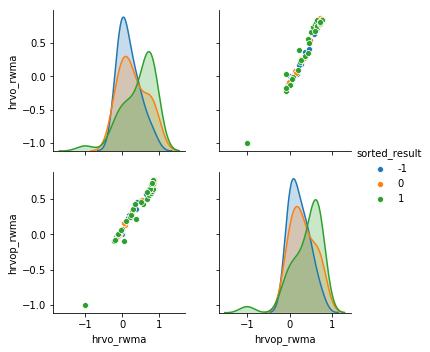

In [26]:
# Look at France vs Spain
temp_df = df[df['sorted_matchup'] == 'Mexico|USA']
sns.pairplot(temp_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

Based on the above, it appears that these incorporatng a feature capturing the record of the team versus the same opponent could help determining match outcomes.  Teams with a positive record versus an specific opponent appear to win matches more often than not.

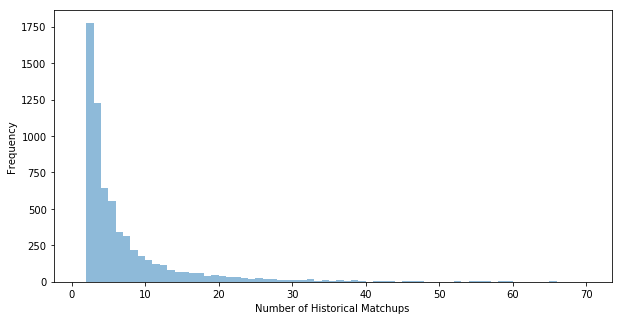

In [27]:
# Check how many matches have taken place for all the matchups in our data set.
matchup_bins = np.linspace(4,99,20)
matchup_bins = np.linspace(1,70,70)
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df_vs_oppo.groupby('sorted_matchup').size(), bins = matchup_bins, alpha = .5)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Historical Matchups')
plt.show()

Based on the histogram above, it appears that most teams have played each other more than five times, which reinforces the notion that we may have enough one-on-one match-up data to generate a useful feature.

### 5.2 - Historical Record vs All Opponents

Defintions:
 - **Historical Record vs All (HRVA):**
     - **hrva_rwma**: Lagging indicator of past performance vs all opponents based on _results_ variable (rolling weighted average)
     - **hrva_rmean**: Lagging indicator of past performance vs all opponents based on _results_ variable (rolling average)


 - **Historical Record vs All "Plus" (HRVAP):**
     - **hrvap_rwma**: Lagging indicator of past performance vs all opponents based on _results_ variable (rolling weighted average)
     - **hrvap_rmean**: Lagging indicator of past performance vs all opponents based on _results-plus_ variable (rolling average)

### 5.2.1 - Generate Features

In [28]:
# Manipulate international results to get a dataframe that looks as follows:
# Date | home | team | tournament | result 

#df_home
df_home = pd.DataFrame(df, 
                       columns = ['date','home_team','tournament','result','result_plus'], 
                       copy = True)
df_home = df_home.rename(columns = {"home_team" : "team"})
df_home['home'] = 1

In [29]:
#df_away
df_away = pd.DataFrame(df, columns = ['date','away_team','tournament'], 
                       copy = True)
df_away = df_away.rename(columns = {"away_team" : "team"})
df_away['result'] = df['result'] * - 1
df_away['result_plus'] = df['result_plus'] * - 1
df_away['home'] = 0

In [30]:
#df_tall (combo of df_home and df_away)
df_tall = df_home.append(df_away, sort = True)

df_tall = df_tall.sort_values('date')

df_tall.set_index('date',inplace=True,drop=True)

#print(len(train_df))
#print(len(df_tall))
df_tall.head()



,home,result,result_plus,team,tournament
date,,,,,
1872-11-30,1,0,-0.25,Scotland,Friendly
1872-11-30,0,0,0.25,England,Friendly
1873-03-08,1,1,0.75,England,Friendly
1873-03-08,0,-1,-0.75,Scotland,Friendly
1874-03-07,1,1,0.75,Scotland,Friendly


In [31]:
# Create fake rows to store forward int'l ranking

fake_df = pd.DataFrame(df_tall.team.unique(),columns=['team'])
fake_df['date'] = '2099-12-31'
fake_df.date = fake_df.date.values.astype("datetime64")
fake_df['home'] = '0'
fake_df['result'] = '0'
fake_df['result_plus'] = '0'
fake_df['tournament'] = 'Placeholder'
fake_df.set_index('date', inplace=True)
#fake_df.head()

In [32]:
df_tall = pd.concat([df_tall,fake_df], sort=True)

In [33]:
overall_record_rwma_df = df_tall.groupby('team')['result'].apply(rwma,0,50)
overall_record_rwmap_df = df_tall.groupby('team')['result_plus'].apply(rwma,0,50)

overall_record_rmean_df = df_tall.groupby('team')['result'].apply(rmean,0)
overall_record_rmeanp_df = df_tall.groupby('team')['result_plus'].apply(rmean,0)

overall_record_df = overall_record_rwma_df.copy()

In [34]:
overall_record_df = overall_record_df.rename(columns = {'rwma':'hrva_rwma'})

overall_record_df['hrvap_rwma'] = overall_record_rwmap_df['rwma']

overall_record_df['hrva_rmean'] = overall_record_rmean_df['rmean']

overall_record_df['hrvap_rmean'] = overall_record_rmeanp_df['rmean']

In [35]:
overall_record_df.reset_index(inplace=True)

overall_record_df.drop(columns='level_1', inplace= True)

overall_record_df.hrva_rwma = overall_record_df.hrva_rwma.fillna(0)

overall_record_df.hrvap_rwma = overall_record_df.hrvap_rwma.fillna(0)

overall_record_df.hrva_rmean = overall_record_df.hrva_rmean.fillna(0)

overall_record_df.hrvap_rmean = overall_record_df.hrvap_rmean.fillna(0)

# below is needed to handle duplicates due to certain teams playing two matches on the same date
overall_record_df = overall_record_df.groupby(['team','date']).mean()
overall_record_df = overall_record_df.reset_index()

### 5.2.2 - Examine Features

In [36]:
temp_df1 = overall_record_df[(overall_record_df['team'] == 'France') & (overall_record_df['date'] < '2099-12-31')]
temp_df2 = overall_record_df[(overall_record_df['team'] == 'Spain')  & (overall_record_df['date'] < '2099-12-31')]
temp_df3 = df_vs_oppo[df_vs_oppo['sorted_matchup'] == 'France|Spain']

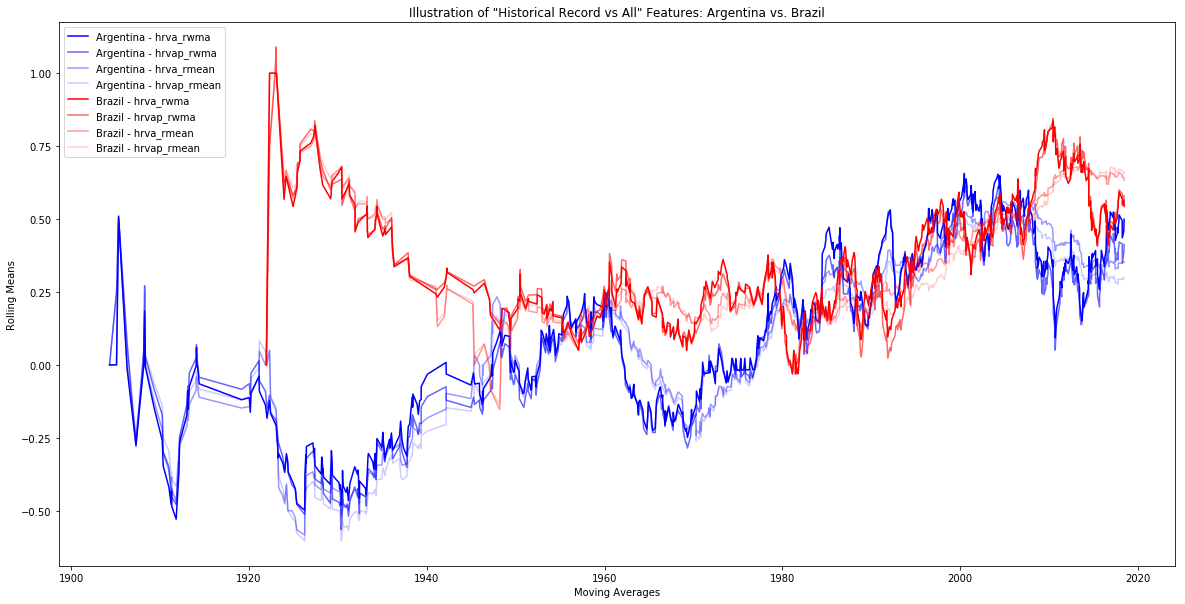

In [37]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

ax.plot(temp_df1['date'], temp_df1['hrva_rwma'], label = 'Argentina - hrva_rwma', color = 'blue', alpha = 1)
ax.plot(temp_df1['date'], temp_df1['hrvap_rwma'], label = 'Argentina - hrvap_rwma', color = 'blue', alpha = 0.60)

ax.plot(temp_df1['date'], temp_df1['hrva_rmean'], label = 'Argentina - hrva_rmean', color = 'blue', alpha = .40)
ax.plot(temp_df1['date'], temp_df1['hrvap_rmean'], label = 'Argentina - hrvap_rmean', color = 'blue', alpha = .20)


ax.plot(temp_df2['date'], temp_df2['hrva_rwma'], label = 'Brazil - hrva_rwma', color = 'red', alpha = 1)
ax.plot(temp_df2['date'], temp_df2['hrvap_rwma'], label = 'Brazil - hrvap_rwma', color = 'red', alpha = 0.60)

ax.plot(temp_df2['date'], temp_df2['hrva_rmean'], label = 'Brazil - hrva_rmean', color = 'red', alpha = .40)
ax.plot(temp_df2['date'], temp_df2['hrvap_rmean'], label = 'Brazil - hrvap_rmean', color = 'red', alpha = .20)

ax.set_xlabel('Moving Averages')
ax.set_ylabel('Rolling Means')
ax.set_title('Illustration of "Historical Record vs All" Features: Argentina vs. Brazil')

plt.legend()
plt.show()

## 6  - Merge Features Back into Project Dataset

### 6.1  - Merge Historical Record vs All Opponents into Project Dataset

In [38]:
project_df = pd.read_csv("data/team/M4_data_nikhil.csv")
project_df.date = project_df.date.values.astype("datetime64")

project_df = project_df.sort_values(['date','home_team','away_team'])
overall_record_df = overall_record_df.sort_values(['date','team'])

overall_record_df.to_csv('data/team/overall_record_df.csv')

In [39]:
#print(len(project_df))

merge_columms = ['date','team', # for joins
                 'hrva_rwma','hrvap_rwma','hrva_rmean','hrvap_rmean']

final_df = pd.merge_asof(project_df, overall_record_df[merge_columms], 
                  left_on=['date'],
                  right_on=['date'],                    
                  left_by = ['home_team'], 
                  right_by = ['team'], 
                  direction = 'forward',
                  allow_exact_matches = True)

final_df = final_df.drop(columns = 'team')

final_df = final_df.rename(columns={'hrva_rwma':'home_hrva_rwma', 
                                    'hrvap_rwma':'home_hrvap_rwma',
                                    'hrva_rmean':'home_hrva_rmean',
                                    'hrvap_rmean': 'home_hrvap_rmean'
                                    })

#print(len(final_df))

In [40]:
print(len(project_df))

final_df = pd.merge_asof(final_df, overall_record_df[merge_columms], 
                  left_on=['date'],
                  right_on=['date'],                    
                  left_by = ['away_team'], 
                  right_by = ['team'], 
                  direction = 'forward',
                  allow_exact_matches = True)


final_df = final_df.drop(columns = 'team')

#train_df.head()

final_df = final_df.rename(columns={'hrva_rwma':'away_hrva_rwma', 
                                    'hrvap_rwma':'away_hrvap_rwma',
                                    'hrva_rmean':'away_hrva_rmean',
                                    'hrvap_rmean': 'away_hrvap_rmean'
                                    })

print(len(final_df))

1639
1639


In [41]:
#final_df.info()

In [42]:
#final_df.to_csv('data/team/final_df.csv')

In [43]:
final_df['diff_hrva_rwma']   = final_df['home_hrva_rwma']   - final_df['away_hrva_rwma']
final_df['diff_hrvap_rwma']  = final_df['home_hrvap_rwma']  - final_df['away_hrvap_rwma']
final_df['diff_hrva_rmean']  = final_df['home_hrva_rmean']  - final_df['away_hrva_rmean']
final_df['diff_hrvap_rmean'] = final_df['home_hrvap_rmean'] - final_df['away_hrvap_rmean']

### 6.2  - Merge Historical Record vs Opponent into Project Dataset

In [44]:
df['hrvo_rwma'] = np.where(df['home_team'] < df['away_team'], 
                                df['hrvo_rwma'],
                                df['hrvo_rwma'] * -1 )

In [45]:
df['hrvop_rwma'] = np.where(df['home_team'] < df['away_team'], 
                                df['hrvop_rwma'],
                                df['hrvop_rwma'] * -1 )

In [46]:
merge_columms = ['date','home_team','away_team', # for joins
                 'hrvo_rwma' , 'hrvop_rwma']

final_df = pd.merge_asof(final_df, df[merge_columms], 
                  left_on=['date'],
                  right_on=['date'],                    
                  left_by = ['home_team','away_team'], 
                  right_by = ['home_team','away_team'], 
                  direction = 'forward',
                  allow_exact_matches = True)

#if teams never faced each other before, substitute hrvo_rwma and hrvop_rwma with diff_hrva_rwma and diff_hrvap_rwma

final_df['hrvo_rwma'] = final_df['hrvo_rwma'].fillna(final_df['diff_hrva_rwma'])
final_df['hrvop_rwma'] = final_df['hrvop_rwma'].fillna(final_df['diff_hrvap_rwma'])

In [49]:
final_df.to_csv('data/team/final_dataset.csv')

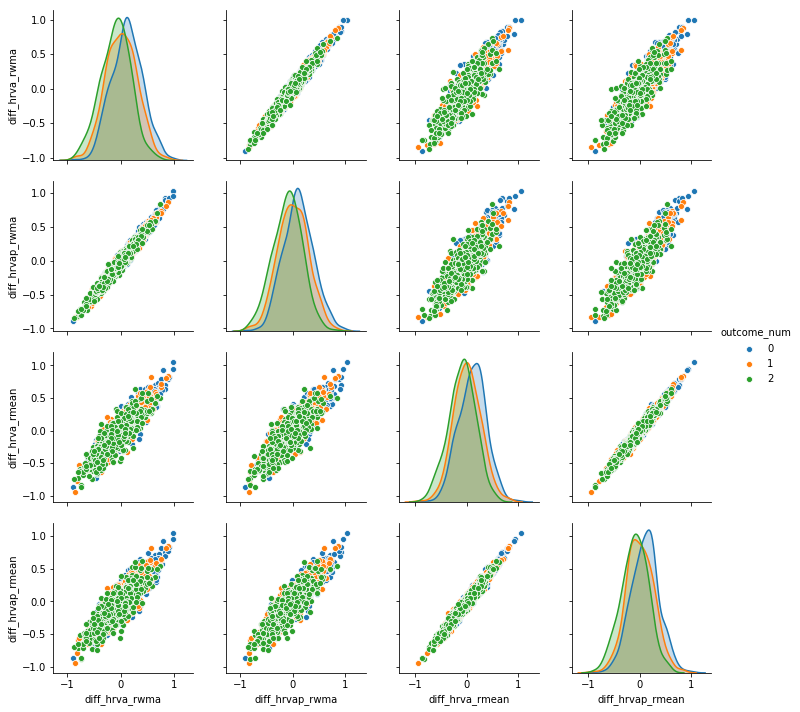

In [50]:
sns.pairplot(final_df, 
             vars = ['diff_hrva_rwma' , 'diff_hrvap_rwma' , 'diff_hrva_rmean' , 'diff_hrvap_rmean'] , 
             hue="outcome_num")

# Remove later - start

In [51]:
x_train = df[['hrvo_rwma']]
y_train = df['result']

In [52]:
x_test = df[['hrvo_rwma']]
y_test = df['result']

In [53]:
simple_logistic_model = LogisticRegressionCV(multi_class = 'ovr', cv=5, penalty='l2')
simple_logistic_model.fit(x_train, y_train)

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(x_train, y_train)
qda.fit(x_train, y_train)

print('Logistic Regression Train Score: ',simple_logistic_model.score(x_train, y_train))
print('Logistic Regression CV Train Score: ',cross_val_score(simple_logistic_model, x_train, y_train, cv=5).mean())
print('LDA Train Score: ',lda.score(x_train, y_train))
print('LDA CV Train Score: ',cross_val_score(lda, x_train, y_train, cv=5).mean())
print('QDA Train Score: ',qda.score(x_train, y_train))
print('QDA CV Train Score: ',cross_val_score(qda, x_train, y_train, cv=5).mean())

Logistic Regression Train Score:  0.553986332574
Logistic Regression CV Train Score:  0.552145118009
LDA Train Score:  0.554485302094
LDA CV Train Score:  0.551646254381
QDA Train Score:  0.554008026901
QDA CV Train Score:  0.552080197402


In [54]:
# choosing lda and qda as they both produced very similar scores on CV data
print('Logistic Regression Test Score: ',simple_logistic_model.score(x_test, y_test))
print('LDA Test Score: ',lda.score(x_test, y_test))
print('QDA Test Score: ',qda.score(x_test, y_test))

Logistic Regression Test Score:  0.553986332574
LDA Test Score:  0.554485302094
QDA Test Score:  0.554008026901


In [55]:
# confusion matrix for the logistic regression model
pd.crosstab(np.array(y_test), simple_logistic_model.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,-1,1,All
Actual,,,
-1,6024,7091,13115
0,2739,7774,10513
1,2955,19512,22467
All,11718,34377,46095


In [56]:
# confusion matrix for the lda model
pd.crosstab(np.array(y_test), lda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,-1,1,All
Actual,,,
-1,6138,6977,13115
0,2822,7691,10513
1,3046,19421,22467
All,12006,34089,46095


In [57]:
# confusion matrix for the qda model
pd.crosstab(np.array(y_test), qda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,-1,1,All
Actual,,,
-1,6158,6957,13115
0,2852,7661,10513
1,3088,19379,22467
All,12098,33997,46095


In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 1638
Data columns (total 80 columns):
date                                1639 non-null datetime64[ns]
home_team                           1639 non-null object
away_team                           1639 non-null object
home_score                          1639 non-null int64
away_score                          1639 non-null int64
tournament                          1639 non-null object
city                                1639 non-null object
country                             1639 non-null object
neutral                             1639 non-null int64
home_rank                           1639 non-null int64
home_rank_pts                       1639 non-null int64
away_rank                           1639 non-null int64
away_rank_pts                       1639 non-null int64
rank_diff                           1639 non-null int64
rank_pts_diff                       1639 non-null int64
outcome                             163

In [59]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 646
Data columns (total 66 columns):
date                                1639 non-null datetime64[ns]
home_team                           1639 non-null object
away_team                           1639 non-null object
home_score                          1639 non-null int64
away_score                          1639 non-null int64
tournament                          1639 non-null object
city                                1639 non-null object
country                             1639 non-null object
neutral                             1639 non-null int64
home_rank                           1639 non-null int64
home_rank_pts                       1639 non-null int64
away_rank                           1639 non-null int64
away_rank_pts                       1639 non-null int64
rank_diff                           1639 non-null int64
rank_pts_diff                       1639 non-null int64
outcome                             1639